In [1]:
from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/Shared drives/ECS174_proj'

Mounted at /content/drive


In [ ]:
%ls '/content/drive/Shared drives/ECS174_proj'

Data/  ecs174_proj.ipynb


In [ ]:
!pip install opencv-python-headless
!pip install numpy
!pip install pycocotools

In [2]:
import json
import numpy as np
import cv2
from pycocotools.coco import COCO
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
import csv
import matplotlib.pyplot as plt
from keras.utils import Sequence

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [ ]:
def csv_writer(images, labels, filename):
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Image', 'Label'])
        for image, label in zip(images, labels):
            csv_writer.writerow([image.tolist(), label.tolist()])

In [ ]:
def load_from_csv(csv_file):
    images = []
    labels = []
    with open(csv_file, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip header
        for row in csv_reader:
            image = np.array(eval(row[0]))  # Convert string back to array
            label = np.array(eval(row[1]))
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

In [4]:

# Data Generator Class
class DataGenerator(Sequence):
    def __init__(self, img_dir, ann_file, batch_size=32, img_size=(256, 256), shuffle=True, subset=None):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.img_size = img_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_ids = self.coco.getImgIds()
        if subset:
            self.img_ids = self.img_ids[:subset]  # Limit dataset size
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.img_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_img_ids = self.img_ids[index * self.batch_size:(index + 1) * self.batch_size]
        images, labels = self.__data_generation(batch_img_ids)
        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.img_ids)

    def __data_generation(self, batch_img_ids):
        images = []
        labels = []
        for img_id in batch_img_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = f"{self.img_dir}/{img_info['file_name']}"
            img = cv2.imread(img_path)
            if img is None:
                continue
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)
            for ann in anns:
                x, y, w, h = ann['bbox']
                category_id = ann['category_id']
                cropped_img = img[int(y):int(y+h), int(x):int(x+w)]
                cropped_img = cv2.resize(cropped_img, self.img_size)
                images.append(cropped_img / 255.0)
                labels.append(1 if category_id == 2 else 0)  # 2 is occupied and 1 is empty
        return images, to_categorical(labels, num_classes=2)

In [5]:
# Directory paths
base_dir = filepath + '/Data'
train_dir = f"{base_dir}/train"
val_dir = f"{base_dir}/valid"
test_dir = f"{base_dir}/test"

# Annotation file paths
train_ann_file = f"{train_dir}/_annotations.coco.json"
val_ann_file = f"{val_dir}/_annotations.coco.json"
test_ann_file = f"{test_dir}/_annotations.coco.json"

# Batch size and image size
batch_size = 10  # Reduced batch size
img_size = (64, 64)  # Reduced image size
subset_size = 500  # Reduced dataset size

In [6]:
print('Running train data generator...')
train_generator = DataGenerator(train_dir, train_ann_file, batch_size=batch_size, img_size=img_size, subset=subset_size)

Running train data generator...
loading annotations into memory...
Done (t=55.84s)
creating index...
index created!


In [7]:
print('Running val data generator...')
val_generator = DataGenerator(val_dir, val_ann_file, batch_size=batch_size, img_size=img_size, subset=subset_size)

Running val data generator...
loading annotations into memory...
Done (t=13.88s)
creating index...
index created!


In [8]:
print('Running test data generator...')
test_generator = DataGenerator(test_dir, test_ann_file, batch_size=batch_size, img_size=img_size, subset=subset_size)

Running test data generator...
loading annotations into memory...
Done (t=8.42s)
creating index...
index created!


In [9]:
import matplotlib.pyplot as plt

def plot_sample_images(images, labels, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title('Empty' if labels[i] == 0 else 'Occupied')
        plt.axis("off")
    plt.show()

def plot_training_curves(train_loss, train_acc, val_acc, title):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.title(f'{title} - Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{title} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def plot_predictions(images, labels, predictions, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"Actual: {'Empty' if labels[i] == 0 else 'Occupied'}\nPredicted: {'Empty' if predictions[i] == 0 else 'Occupied'}")
        plt.axis("off")
    plt.show()

In [10]:
import tensorflow as tf
from keras import layers, models

class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = layers.Conv2D(6, (5, 5), activation='relu')
        self.pool = layers.MaxPooling2D((2, 2))
        self.conv2 = layers.Conv2D(16, (5, 5), activation='relu')
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(120, activation='relu')
        self.fc2 = layers.Dense(84, activation='relu')
        self.fc3 = layers.Dense(2, activation='softmax')

    def call(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)

input_shape = (64, 64, 3)  # Reduced input shape
model = Model()
model.build((None,) + input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  456       
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  2416      
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  324600    
                                                                 
 dense_1 (Dense)             multiple                  10164     
                                                             

In [12]:
# Train the model
print('Training model...')
history = model.fit(train_generator, epochs=10, validation_data=val_generator)  # Reduced epochs

Training model...
Epoch 1/10
50/50 [==============================] - 892s 18s/step - loss: 0.3227 - accuracy: 0.8710 - val_loss: 0.2099 - val_accuracy: 0.9415
Epoch 2/10
50/50 [==============================] - 18s 351ms/step - loss: 0.1937 - accuracy: 0.9518 - val_loss: 0.1864 - val_accuracy: 0.9556
Epoch 3/10
50/50 [==============================] - 16s 314ms/step - loss: 0.1505 - accuracy: 0.9607 - val_loss: 0.1592 - val_accuracy: 0.9614
Epoch 4/10
50/50 [==============================] - 17s 338ms/step - loss: 0.1286 - accuracy: 0.9677 - val_loss: 0.1495 - val_accuracy: 0.9615
Epoch 5/10
50/50 [==============================] - 16s 327ms/step - loss: 0.1305 - accuracy: 0.9665 - val_loss: 0.1500 - val_accuracy: 0.9647
Epoch 6/10
50/50 [==============================] - 16s 315ms/step - loss: 0.1067 - accuracy: 0.9738 - val_loss: 0.1496 - val_accuracy: 0.9657
Epoch 7/10
50/50 [==============================] - 16s 312ms/step - loss: 0.1179 - accuracy: 0.9720 - val_loss: 0.1331 - val

In [13]:
# Save the model
print('Saving model...')
#model.save(filepath+'/model.h5')  # Save as H5 file
model.save(filepath+'/saved_model_10')  # Save as TensorFlow SavedModel format

# Load the model
# loaded_model = tf.keras.models.load_model(filepath+'/model.h5')train_loss = history.history['loss']

Saving model...


In [14]:
train_acc = history.history['accuracy']

In [15]:
val_acc = history.history['val_accuracy']

In [16]:
train_loss = history.history['loss']

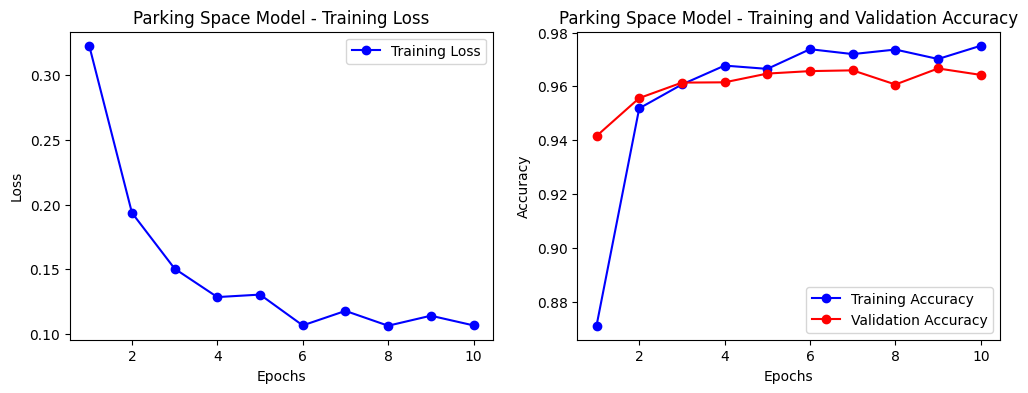

In [17]:
# Plot training history
plot_training_curves(train_loss, train_acc, val_acc, 'Parking Space Model')

In [18]:
# Evaluate the model
print('Evaluating model...')
test_images, test_labels = test_generator.__getitem__(0)

Evaluating model...


In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {accuracy * 100:.2f}%")

20/20 [==============================] - 0s 7ms/step - loss: 0.0283 - accuracy: 0.9984
Test accuracy: 99.84%


20/20 [==============================] - 0s 2ms/step
Number of empty spaces in the test set: 252


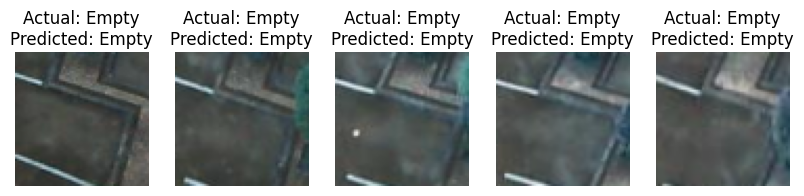

In [23]:
# Predict the labels of the test images
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Print the number of empty spaces in the test set
num_empty_spaces = np.sum(predicted_labels == 0)
print(f"Number of empty spaces in the test set: {num_empty_spaces}")

# Plot predictions vs actual labels
def plot_predictions(images, labels, predictions, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"Actual: {'Empty' if labels[i] == 0 else 'Occupied'}\nPredicted: {'Empty' if predictions[i] == 0 else 'Occupied'}")
        plt.axis("off")
    plt.show()

plot_predictions(test_images, np.argmax(test_labels, axis=1), predicted_labels)